In [1]:
import sys
sys.path.append('/Users/liushuhan/Documents/AL_GNN/Experiments/RSP/Sythentic_graph')
from const_l2 import *
from noconst_l2 import *
from Generator import *

import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import get_laplacian, to_dense_adj, from_networkx, to_networkx
import networkx as nx
import seaborn as sb
from scipy.linalg import solve_sylvester

/Users/liushuhan/Documents/AL_GNN/Experiments/RSP/Sythentic_graph/Generator.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_mean = torch.tensor(group_mean[group_label[i],])


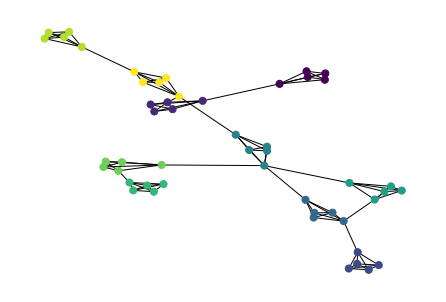

In [2]:
list_shapes = ['nx.complete_graph'] * 10
list_shapes_args = [[5]] * 10
graph_type = 'nx.connected_watts_strogatz_graph'
graph_args = [10, 2, 0.4]
G, Gg, group_label, shape_label, shape_dist = synthetic_graph_generator(list_shapes, list_shapes_args, graph_type, graph_args, \
    plot=True, plot_color='group_label', savefig=False, root=None, figname=None)
node_features, group_mean = synthetic_feature_generator(group_label, num_features=50, std=0.1, save=False, root=False) 

In [3]:
data = from_networkx(G)
L = to_dense_adj(get_laplacian(data.edge_index)[0], edge_attr=get_laplacian(data.edge_index)[1])[0]

## Without constraint

### Directly solve sylvester equation

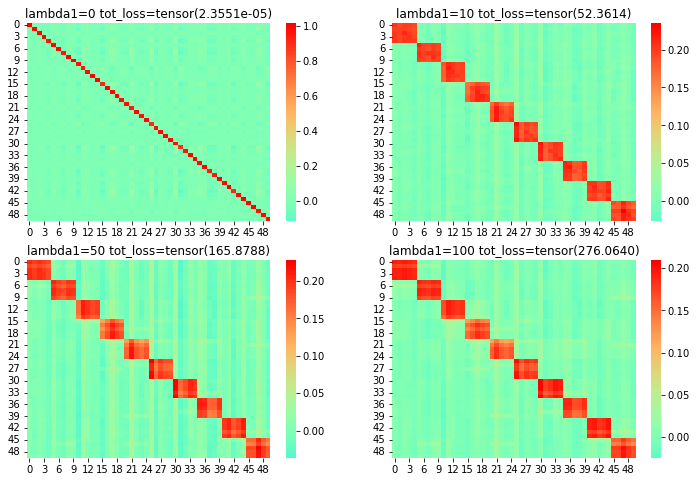

In [4]:
# the optimal W when there is no constraint
lambda1 = [0, 10, 50, 100]
num = len(lambda1)

f = plt.figure(figsize=(12,8))
for i in range(num):
    ax0 = f.add_subplot(eval('22'+str(i+1)))
    a = (L*lambda1[i]).numpy() # recon_avg=True
    b = torch.matmul(node_features, node_features.t()).numpy()
    q = torch.matmul(node_features, node_features.t()).numpy()
    W = solve_sylvester(a,b,q)
    sb.heatmap(W, cmap='rainbow', center=0)
    loss = compute_loss(torch.tensor(W), L*lambda1[i], node_features)
    ax0.set_title('lambda1='+str(lambda1[i])+' '+'tot_loss='+str(loss[0]))

### Use proximal grdient algorithm 

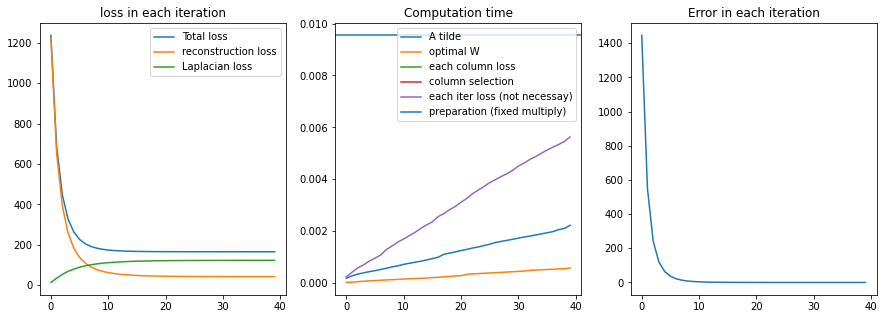

In [7]:
# the trend of Lap loss is related to how to initialize W
W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_no(X=node_features, L=L, lambda1=1*G.number_of_nodes(), epsilon=1e-3, ratio=1,\
     max_iter=100, init_method='zero', plot=True)

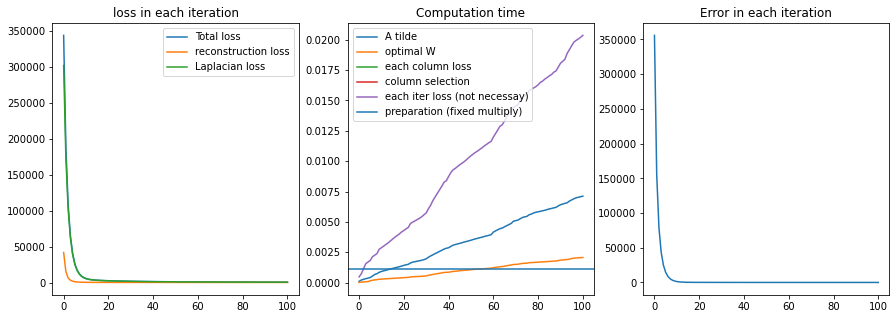

In [8]:
W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_no(X=node_features, L=L, lambda1=1*G.number_of_nodes(), epsilon=1e-3, ratio=1,\
     max_iter=100, init_method='rand', plot=True)

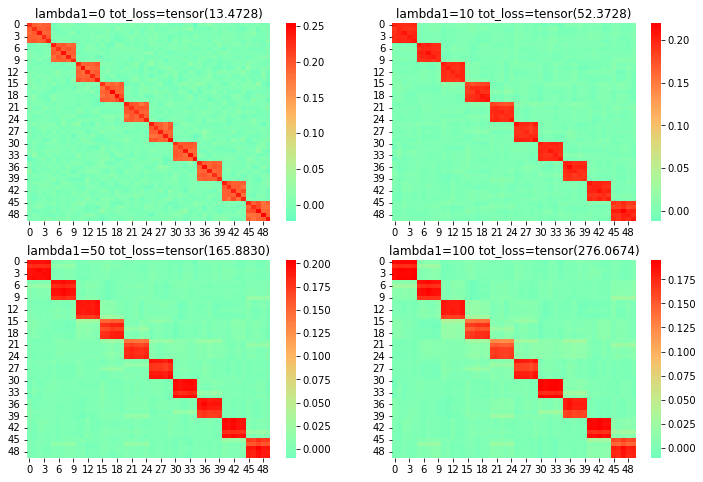

In [9]:
# zero initialization, orginal scale, node_feature
lambda1 = [0, 10, 50, 100]
num = len(lambda1)

f = plt.figure(figsize=(12,8))
for i in range(num):
    ax0 = f.add_subplot(eval('22'+str(i+1)))
    W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_no(X=node_features, L=L, lambda1=lambda1[i], epsilon=1e-3, ratio=1,\
     max_iter=100, init_method='zero', plot=False)
    sb.heatmap(W, cmap='rainbow', center=0)
    loss = compute_loss(W, L*lambda1[i], node_features)
    ax0.set_title('lambda1='+str(lambda1[i])+' '+'tot_loss='+str(loss[0]))

### With l20 constraint 

tensor(806.3157)


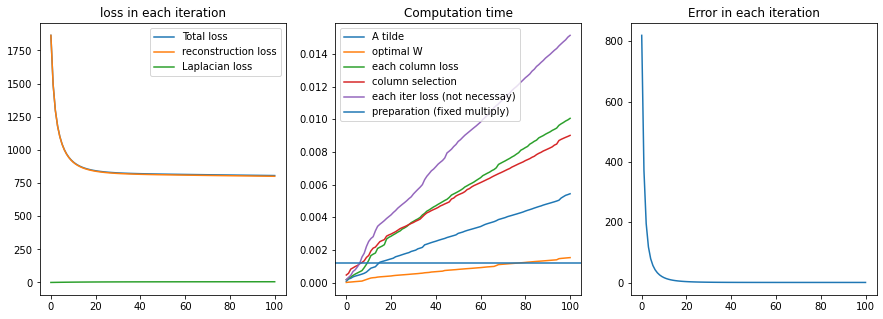

In [12]:
W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_l2(X=node_features, L=L, r=20, lambda1=1, epsilon=1e-3, ratio=1, max_iter=100, init_method='zero', \
    plot=True, training_mask=None)
print(total_loss_rec[len(total_loss_rec)-1])

tensor(1218.9092)


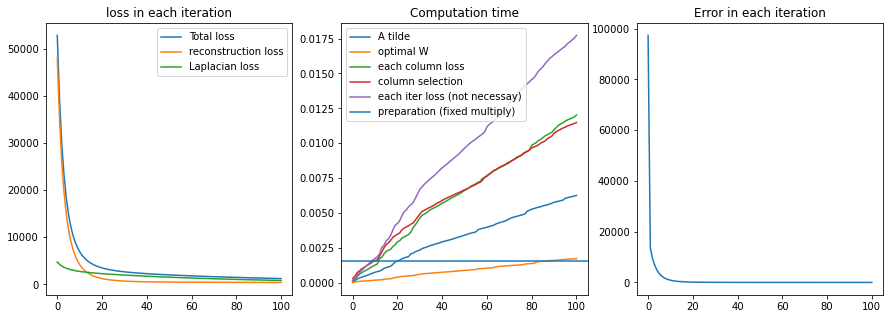

In [13]:
W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_l2(X=node_features, L=L, r=20, lambda1=1, epsilon=1e-3, ratio=1, max_iter=100, init_method='rand', \
    plot=True, training_mask=None)
print(total_loss_rec[len(total_loss_rec)-1])

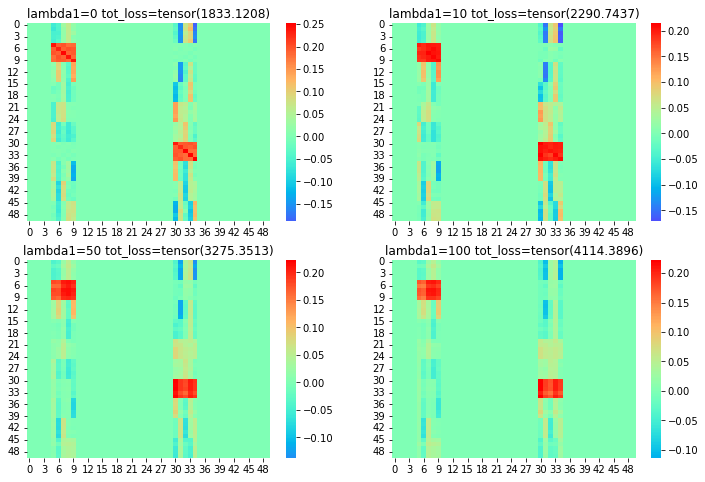

In [19]:
# averge the recon loss, change the values for lambda1
lambda1 = [0, 10, 50, 100]
num = len(lambda1)

f = plt.figure(figsize=(12,8))
for i in range(num):
    ax0 = f.add_subplot(eval('22'+str(i+1)))
    W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_l2(X=node_features, L=L, r=10, lambda1=lambda1[i], epsilon=1e-3, ratio=1, \
        max_iter=100, init_method='zero', plot=False, training_mask=None)
    sb.heatmap(W, cmap='rainbow', center=0)
    loss = compute_loss(W, L*lambda1[i]*G.number_of_nodes(), node_features)
    ax0.set_title('lambda1='+str(lambda1[i])+' '+'tot_loss='+str(loss[0]))

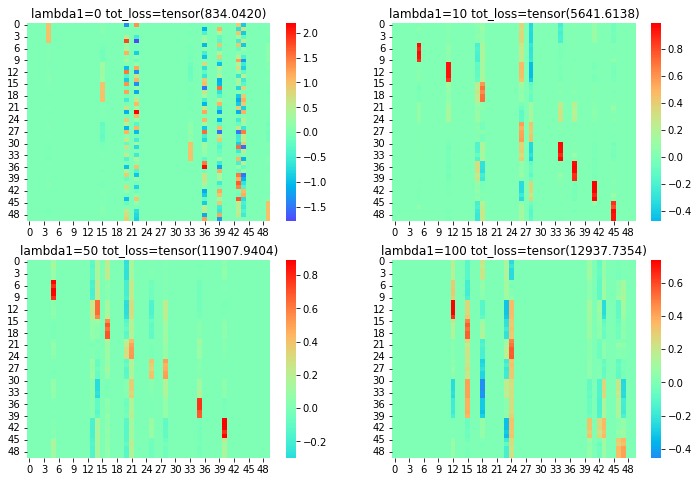

In [15]:
# averge the recon loss, change the values for lambda1
lambda1 = [0, 10, 50, 100]
num = len(lambda1)

f = plt.figure(figsize=(12,8))
for i in range(num):
    ax0 = f.add_subplot(eval('22'+str(i+1)))
    W, total_loss_rec, recon_loss_rec, lap_loss_rec, error_rec = const_l2(X=node_features, L=L, r=10, lambda1=lambda1[i], epsilon=1e-3, ratio=1, \
        max_iter=100, init_method='rand', plot=False, training_mask=None)
    sb.heatmap(W, cmap='rainbow', center=0)
    loss = compute_loss(W, L*lambda1[i]*G.number_of_nodes(), node_features)
    ax0.set_title('lambda1='+str(lambda1[i])+' '+'tot_loss='+str(loss[0]))

If same embeeding within subgraph + init = zero: -- tend to select nodes from the same subgraph \
If same embeeding within subgraph + init = rand: -- tend to distribute nodes, but larger loss \
not stable using randn, different initialization